## Algorithm Design

### Initialization Methods

In [66]:
def get_memory_map_index(mem_place_key):
    # Utilizing a map for a global state of memory.  
    # Allowing me to utilize a multiD array for storage with the lookup benefits of a hashmap.
    mem_map = {
        # Memory is stored in: indices 0 = history, 1 = action, 2 = reward, 3 = next_history, 4 = dead
        # Index constants:
        'history': 0,
        'action': 1,
        'reward': 2,
        'next_history': 3,
        'dead': 4,
    }
    return mem_map[mem_place_key]

def get_rand_action():
    return random.randrange(0, ACTION_OPTION_COUNT)

def init_steps(env):
    # Step into the game an arbitrary number of times betw. 1 and a initialization constant.
    for _ in range(random.randint(1, INIT_NO_OP_STEPS)):
        # A step to 1 signal no action (FIRE action is index 1 and no-op) 
        #  This forwards into more pivotal inital frames.
        res_state, _, _, _ = env.step(1)
    return res_state

def get_log_dir():
    curr_time = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    record_dir = TRAIN_DIR + "/openai-atari-{}-logger".format(curr_time)

def init_file_writer_to_local_dir():
    return tf.summary.FileWriter(get_log_dir(), tf.get_default_graph())

def conv_obj(test):
    temp = []
    for i, v in enumerate(test):
        temp.insert(len(temp), test[v])
    return tuple(temp)

def init_config(selected_env = ""):
    configs = {
        'deep_q_state': conv_obj({
            'env': gym.make(selected_env),
            # Deque is imported from collections.  Set to a finite size.  New memory will overwrite old.
            'memory': deque(maxlen=MAX_MEMORY_SIZE),
            # init
            'epsilon': 1.0,
            'total_steps': 0,
            # Init at 0.
            'player_game': 0,
        }),
        'deep_q_game_state': conv_obj({
            'done': False,
            'dead': False,
            'game_step': 0,
            'game_score': 0,
            'game_lives': 5,
            'game_loss': 0.0,
        }),
        'metrics': conv_obj({
            # Initialize storage for collecting data on model performance.
            'total_score': 0,
            'score_interval_count': 0,
            'avg_game_scores': [],
            'max_score': 0,
            'max_scores': [],
        }),
        'mem_defaults': conv_obj({
            'hist': [],
            'action': 1,
            'reward': -1,
            'hist_next': [],
            'dead': False,
        }),
        'batch_matrix': np.zeros(tuple([BATCH_SIZE] + list(ATARI_IMAGE_SHAPE))),
    }
    return configs

def init_test_config(selected_env = "", LOGS_FILE_PATH = ""):
    configs = {
        'deep_q_test_state': conv_obj({
            'env': gym.make(selected_env),
            'player_games': 0,
            'epsilon': 0.001,
            'global_step': NUM_OBSERVABLE_STEPS + 1,
            'model': load_model(LOGS_FILE_PATH, custom_objects={'huber_loss': huber_loss}),
        }),
    }
    return configs

def preprocess(res_state):
    grayscale_imgs = np.mean(res_state, axis=2)
    shrunk_imgs = resize(grayscale_imgs, ATARI_IMAGE_SHAPE[:2], mode='constant')
    processed_res_state = np.uint8(shrunk_imgs * 255)
    return processed_res_state

def init_history(res_state):
    # At start of game, there is no preceding frame.
    # So just copy initial states to make a starting state.
    state = preprocess(res_state)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], ATARI_IMAGE_STACK_DIMS)
    return history

def get_model_clone(model):
    # Clone model using keras api function.
    model_clone = clone_model(model)
    # Clone model weights to new model separately
    model_clone.set_weights(model.get_weights())
    return model_clone

### CNN

In [67]:
# This architectural CNN is from the mind of Deep Mind.
def cnn_model():
    # This model building approach uses the Keras Functional API.
    # The Keras Functional API can be found at: https://keras.io/guides/functional_api/
    image_framework = layers.Input(ATARI_IMAGE_SHAPE, name='image-shape-framework')
    # Normalize 0-255 image scale to within the constraints of 0 and 1.
    # This is done last minute because it is a heavy load to store normalized images, but they
    # can more easily be transformed into processing by the model.
    normalized_images = layers.Lambda(lambda x: x / 255.0, name='normalize-images')(image_framework)

    layer_one_hidden = layers.convolutional.Conv2D(
        LAYER_1_SIZE, LAYER_1_FILTER, strides=LAYER_1_STRIDES, activation=ACTIVATION_FUNCTION
    )(normalized_images)
    layer_two_hidden = layers.convolutional.Conv2D(
        LAYER_2_SIZE, LAYER_2_FILTER, strides=LAYER_2_STRIDES, activation=ACTIVATION_FUNCTION
    )(layer_one_hidden)
    # Flatten before connecting to move to 1D structure.
    flat_layer = layers.core.Flatten()(layer_two_hidden)
    # Dense layer, fully connected.
    fully_connected_layer = layers.Dense(256, activation=ACTIVATION_FUNCTION)(flat_layer)
    # Dense layer is fully connected.  This is the layer that is fully connected, mapping to the action probabilities
    action_layers = layers.Dense(ACTION_OPTION_COUNT)(fully_connected_layer)
    # Action mask encodes.  Format is conforming to the result of action probabilities
    action_input = layers.Input((ACTION_OPTION_COUNT,), name='action-mask')
    # Multiply layer for each action using the encoded action mask.
    # Element-wise multiplication of action mask by action layers (selecting for all actions)
    mult_res_layer = layers.Multiply(name='deep-q-cnn')([action_layers, action_input])

    model = Model(inputs=[image_framework, action_input], outputs=mult_res_layer)
    model.summary()
    # RMSProp is commonly used for minibatch learning.
    # rho adjusts the influence of the past gradient
    optimizer = RMSprop(lr=LEARNING_RATE, rho=0.95, epsilon=REGULATION_SCALE)
    model.compile(optimizer, loss=huber_loss)
    return model

### Helper Methods

In [78]:
def get_config(selected_env, config_type):
    return init_config(selected_env)[config_type]

def get_test_config(selected_env, logs_path, config_type):
    return init_test_config(selected_env, logs_path)[config_type]

# Action is random if it is an observed state or if by chance based on the epsilon threshold, it is.
# If action is not random it gets generated from the current model based on history data to this point.
# I select the best action from this result.
def get_action(history, epsilon, model, is_in_observed_state):
    # If is_in_observed_state go with random action, otherwise predict it from the model.
    is_below_epsilon_threshold = np.random.rand() <= epsilon
    if is_below_epsilon_threshold or is_in_observed_state:
        return get_rand_action()
    else:
        # Get all Q(s, a) possibilities and take largest probability for optimal reward.
        q_value = model.predict([history, np.ones(ACTION_OPTION_COUNT).reshape(1, ACTION_OPTION_COUNT)])
        max_poss_optimal_reward = np.argmax(q_value[0])
    # Offset for 0 indexing of the encoding array location of value
    return max_poss_optimal_reward

def update_epsilon(total_steps, epsilon):
    training = (total_steps > NUM_OBSERVABLE_STEPS)
    epsilon_declining = epsilon > EPSILON_MIN
    if epsilon_declining and training:
        epsilon -= EPSILON_DECAY
    return epsilon

def find_state_and_history(res_state, history):
    next_state = preprocess(res_state)
    next_state = np.reshape([next_state], ATARI_IMAGE_DIMS)
    # Append the state from the agent's step with the last three most recent frames from the history.
    next_history = np.append(next_state, history[:, :, :, :3], axis=3)
    return (next_state, next_history)

def update_game_lifecycle(game_lives, info):
    # Check if the game is over if the agent lost their lives.
    # This info hashmap doesn't contain added information.
    game_dead = game_lives > info['ale.lives']
    # Update game_lives state to match with what the env. knows.
    game_lives = info['ale.lives']
    return (game_dead, game_lives)

def breakout_from_memory(memory, selected_env):
    training_batch = random.sample(memory, BATCH_SIZE)
    history_state = get_config(selected_env, 'batch_matrix')
    next_history_state = get_config(selected_env, 'batch_matrix')
    action, reward, dead = [], [], []

    # [:, x] is a np trick for selecting all items for a column at index, 'x'.
    batch = np.array(training_batch, dtype=object)
    action = batch[:, get_memory_map_index('action')].tolist()
    reward = batch[:, get_memory_map_index('reward')].tolist()
    dead = batch[:, get_memory_map_index('dead')].tolist()
    
    # Reorganize 2D matrix array into category sets by column.
    for index, val in enumerate(training_batch):
        history_state[index] = val[get_memory_map_index('history')]
        next_history_state[index] = val[get_memory_map_index('next_history')]
        
    return (history_state, next_history_state, action, reward, dead)

def map_data_to_memory_location(action, history, next_history, reward, player_dead, selected_env):
    mem_storage = list(get_config(selected_env, 'mem_defaults'))
    mem_storage[get_memory_map_index('action')] = action
    mem_storage[get_memory_map_index('history')] = history
    mem_storage[get_memory_map_index('next_history')] = next_history
    mem_storage[get_memory_map_index('reward')] = reward
    mem_storage[get_memory_map_index('dead')] = player_dead
    return mem_storage

def get_one_hot_encoding(targets, nb_classes):
    # array for hot mapping each action
    # classes: 3, targets range from 0 to 2.  
    # The reshape -1 signifies that data is massaged into a dimension that is unknown.
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

# Huber Loss has a standard formula to maximize loss given complexities in loss variance 
# depending on the size of an image.
# Calculated by using MSE and MAE
def huber_loss(a, b):
    error = K.abs(a - b)
    quadratic_term = K.clip(error, 0.0, 1.0)
    linear_term = error - quadratic_term
    loss = K.mean(0.5 * K.square(quadratic_term) + linear_term)
    return loss


### Debugging Method
It is not necessary to run this but the training is so long it is useful to check in on how it is performing.
Some iterative logging function should be run in case the model quits while the programmer is sleeping or something.

In [79]:
def maybe_log_metrics(player_game, total_score, score_interval_count, loss, model, step, file_writer, score):
    if player_game % SCREEN_LOG_FREQUENCY == 0:
        avg_score = round((total_score/score_interval_count), 2)
        print("game: {}, avg_score: {},".format(player_game, avg_score))
        
    # Record model state iteratively since run time is long.    
    if player_game % 1000 == 0 or (player_game + 1) == NUM_GAMES:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        file_name = "openai-{}-time.h5".format(now)
        model_path = os.path.join(TRAIN_DIR, file_name)
        model.save(model_path)

    # Update File for storing keras stats.
    loss_summary = tf.Summary(
        value=[tf.Summary.Value(tag="loss", simple_value=loss / float(step))])
    file_writer.add_summary(loss_summary, global_step=player_game)

    score_summary = tf.Summary(
        value=[tf.Summary.Value(tag="score", simple_value=score)])
    file_writer.add_summary(score_summary, global_step=player_game)
        

### Deep Q-Network Methods

In [80]:
def find_future_rewards_from_q(dead, reward, next_q_values):
    # Apply Bellman's equation if agent is not dead.  Results should converge eventually.
    # Q Learning, get maximum Q value given (state, action)
    # Predict Q(s', a') from thetarget model
    q_s_a = np.zeros((BATCH_SIZE,))
    for i in range(BATCH_SIZE):
        if not dead[i]:
            # Q(s, a) = r + gamma * max(Q(s', a')).  Bellman's equation for Q value.
            # Train model (s, a) pairs to estimation of future rewards.
            q_s_a[i] = reward[i] + GAMMA * np.amax(next_q_values[i])
        else:
            # If the agent died there is no future reward predicted.
            # Reward doesn't need to be updated if there is no further future reward possible.
            q_s_a[i] = reward[i]
    return q_s_a

def train_memory_batch(memory, model, log_dir, selected_env):
    history_state, next_history_state, action, reward, dead = breakout_from_memory(memory, selected_env)
    # Hot Encode each action as on.
    actions_mask = np.ones((BATCH_SIZE, ACTION_OPTION_COUNT))
    # Predict for each action with a mask to select for all actions.
    next_q_values = model.predict([next_history_state, actions_mask])
    
    # Use Bellmans to find future rewards for each memory state, for eac action.
    # (indexing stays constant between qsa and each batch assessment)
    q_s_a = find_future_rewards_from_q(dead, reward, next_q_values)

    # For each action in the batch, encode it using one-hot encoding.
    # Resulting array from [0, 1, 2] would be [[1, 0, 0], [0, 1, 0], [0, 0, 1]] for instance.
    action_one_hot_enc = get_one_hot_encoding(action, ACTION_OPTION_COUNT)
    # Multiply the Q(s, a) value into the action matrix using the binary mask.
    # The encoded rewards matrix will have the reward for Q(s, a) in place of the 1 in the actions encoding.
    rewards_one_hot_enc = action_one_hot_enc * q_s_a[:, None]
    
    model_input = [history_state, action_one_hot_enc]
    model_prediction = rewards_one_hot_enc
    
    # Training Data is a tuple of: (history array, actions encoded) by history batch index.
    # Label Data is (rewards encoding) by history batch index.
    # When predicting, the highest reward will be pulled from the one hot encoded action array.
    h = model.fit(
        model_input, model_prediction, epochs=1,
        batch_size=BATCH_SIZE, verbose=0)

    return (model, h.history['loss'][0])

# This function parents the deep Q Network if the model has enough memory for batch training.
def deep_q_iteration_training(memory, total_steps, model_clone, model, selected_env):
    log_dir = None
    model, loss = train_memory_batch(memory, model, log_dir, selected_env)
    if total_steps % MODEL_WEIGHTS_REFRESH_THRESOLD == 0:
        # Weights on the model clone get piped through so they only get updated as often as 
        # the interval treshold constant dictates the target network should update them.
        model_clone.set_weights(model.get_weights())
    return (model, model_clone, loss)

### Training Method

In [81]:
# Mostly this function keeps track of system states, memory, and flags.
# It provides the opportunity to create logs for debugging.
# Most importantly it takes an action and updates a score.
# It runs training on the model if all observation has been done.  This is Deep Q Learning.
def train(selected_env):
    # Initialize global states.
    # Initialize replay memory D to capacity N.
    env, memory, epsilon, total_steps, player_games = get_config(selected_env,'deep_q_state')
    total_score, score_interval_count, avg_game_scores, max_score, max_scores = get_config(selected_env, 'metrics')
    # Get a copy of the cnn model with the architecture defined in a separate function.
    model = cnn_model()
    
    # Initialize file writer.  
    # Used for logging and storing the model iteratively to preserve work.
    file_writer = init_file_writer_to_local_dir()
    
    # The main model gets used in the Q learning training, and based on updated weights, 
    # then also updates the model clone.  
    # Targeted Network update.  Initialize action-value function Q with random weights.
    model_clone = get_model_clone(model)
    
    # A loop to cover the range of the global number of games played.
    # The player games number is kept visible to the program for logging purposes.
    while player_games < NUM_GAMES:
        # Define global game states.
        game_done, player_dead, game_step, game_score, game_lives, game_loss = get_config(selected_env, 'deep_q_game_state')
        # Reset the environment at the beginning of each game.
        res_state = env.reset()

        # Step into the game an arbitrary number of times betw. 1 and a initialization constant.
        res_state = init_steps(env)
        
        # Prefill the start state with 4 frames.
        # Frames are a constructed empty 84 x 84 2D array x 4 frames to create a state.
        history = init_history(res_state)

        # Have the agent play a game given their turn.
        while not game_done:
            # Set states that define the phases of the observation and training.
            is_in_observed_state = (total_steps <= NUM_OBSERVABLE_STEPS)
            is_in_training_state = not is_in_observed_state
            
            # Get an an action for the agent.
            action = get_action(history, epsilon, model_clone, is_in_observed_state)
            
            # Epsilon decays iteratively with the rate of: ((start val - final val)/num games).
            epsilon = update_epsilon(total_steps, epsilon)

            # Move the agent using the determined action.
            # Update it so the game env understands it.
            observed_img, reward, game_done, info = env.step(action + 1)
            
            # Update the score based on the reward from the agent action.
            game_score += reward
            
            # Preprocess image frame of data returned from the agent's step.
            # Merge this frame with the three most recent last frames in the history.
            # This window of the current frame + three most recent history frames === the current state.
            next_state = preprocess(observed_img)
            next_state = np.reshape([next_state], ATARI_IMAGE_DIMS)
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)
            
            # Get info from env. info on agent status and their current life in the game.
            player_dead, game_lives = update_game_lifecycle(game_lives, info)
            
            # Update memory storage into the appropriate slot.
            mem_storage = map_data_to_memory_location(action, history, next_history, reward, player_dead, selected_env)
            
            # Update the memory with info on the game state.
            # The memory is the source from which batch updates draw to make up Q(s, a) for the model.
            memory.append(tuple(mem_storage))
            
            # Deep Q learning begins if the observational state is complete.
            # When the model has sufficiently recorded enough memory for training,
            # start fitting the model in batches using estimated optimal rewards and update prediction model's
            # weights.
            # Sample random minibatch of transitions from memory for terminal and non-terminal.
            if is_in_training_state:
                model, model_clone, model_loss = deep_q_iteration_training(memory, total_steps, model_clone, model, selected_env)
                # Game loss is a metric that potentially could be logged form performance.
                game_loss += model_loss
                
            if not player_dead:
                # Update history to include the state if the agent didn't die.
                history = next_history
            
            # Update counts and state flags.
            player_dead = False
            # These metrics are used more of less for logging and aren't too important to the system.
            total_steps += 1
            game_step += 1
            
            if game_done:
                # Update the total game score for the metric logs that the function returns.
                total_score += game_score
                score_interval_count += 1
                max_score = max(max_score, game_score)
                maybe_log_metrics(player_games, total_score, score_interval_count, game_loss, model, game_step, file_writer, game_score)
                player_games += 1
                # Take a log sample and reset game score counter for the interval.
                if player_games % SAMPLE_SCORE_INTERVAL == 0:
                    avg_game_score = round((total_score/SAMPLE_SCORE_INTERVAL), 2)
                    avg_game_scores.append(avg_game_score)
                    max_scores.append(max_score)
                    total_score = 0
                    score_interval_count = 0
    file_writer.close()
    return (avg_game_scores, max_scores)

### Test Method

In [82]:
def test(selected_env, log_file_path):
    env = gym.make(selected_env)
    player_games = 0
    epsilon = 0.001
    global_step = NUM_OBSERVABLE_STEPS + 1
    model = load_model(log_file_path, custom_objects={'huber_loss': huber_loss})
    total_score = 0
    avg_game_scores = []
    env, player_games, epsilon, global_step, model = get_test_config(selected_env, log_file_path, 'deep_q_test_state')

    while player_games < NUM_GAMES:
        # init variables
        done, player_dead, game_step, game_score, game_lives, game_loss = get_config(selected_env, 'game')
        
        res_state = env.reset()

        # Start with 4 blank initial frames to construct an initial four frame history
        # after one no-op step into the env (step 1 maps to no-op).
        res_state, _, _, _ = env.step(1)
        history = init_history(res_state)

        while not done:
            if RENDER is True:
                env.render()
                time.sleep(0.01)

            is_in_observed_state = (global_step <= NUM_OBSERVABLE_STEPS)
            # Get action for the current history and go one step in environment
            action = get_action(history, epsilon, model, is_in_observed_state)

            res_state, reward, done, info = env.step(action+1)
            
            next_state, next_history = find_state_and_history(res_state, history)

            game_dead, game_lives = update_game_lifecycle(game_lives, info)

            if not game_dead:
                # Update history to include the state if the agent didn't die.
                history = next_history

            # Update counts and state flags.
            # move reward to the poles of 1 or -1 per the deep mind paper's suggestion
            game_reward = np.clip(reward, -1., 1.)
            game_score += game_reward
            dead = False
            
            if done:
                player_games += 1
                # update average game score log
                total_score += game_score
                # take sample
                if player_games % SAMPLE_SCORE_INTERVAL == 0:
                    avg_game_score = round((total_score/SAMPLE_SCORE_INTERVAL), 2)
                    avg_game_scores.append(avg_game_score)
                    total_score = 0
    return avg_game_scores

## Implementation

### Imports

In [83]:
%%capture
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os.path
import time

from keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model
from keras.models import clone_model
from keras.callbacks import TensorBoard
from skimage.color import rgb2gray
from skimage.transform import resize
from datetime import datetime
from collections import deque
from scipy.interpolate import make_interp_spline

### Constants

In [84]:
def get_action_meanings(ENV_NAME):
  test_env = gym.make(ENV_NAME)
  count_meaning = test_env.unwrapped.get_action_meanings()
  return count_meaning

def get_action_count(ENV_NAME):
  return len(get_action_meanings(ENV_NAME)) - 1

TRAIN_DIR = 'openai_breakout_training_storage'
LOGS_FILE_PATH_BREAKOUT = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/at-20201203045323-time-BreakoutDeterministic-v4.h5'
LOGS_FILE_PATH_QBERT = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/at-20201202210524-time-QbertDeterministic-v4.h5'
LOGS_FILE_PATH_TEST = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/openai-20201205031021-time.h5'
# suggested by Deep Mind Paper
ATARI_IMAGE_SHAPE = (84, 84, 4)
ATARI_IMAGE_DIMS = (1, 84, 84, 1)
ATARI_IMAGE_STACK_DIMS = (1, 84, 84, 4)
ATARI_IMAGE_SHAPE = (84, 84, 4)
ACTION_OPTION_COUNT = 3
RENDER = True
# Other Constants
MAX_MEMORY_SIZE = 400000
ATARI_BREAKOUT_ENV_NAME = 'BreakoutDeterministic-v4'
ATARI_SPACE_ENVADERS_ENV_NAME = 'SpaceInvadersDeterministic-v4'
ATARI_SKIING_ENV_NAME = 'SkiingDeterministic-v4'
ATARI_TENNIS_ENV_NAME = 'TennisDeterministic-v4'
QBERT_ENV_NAME = 'QbertDeterministic-v4'
PONG_ENV_NAME = 'PongDeterministic-v4'
FREEWAY_ENV_NAME = 'FreewayDeterministic-v4'
REGULATION_SCALE = 0.01

# Constants suggested by Deep Mind Paper
LAYER_1_SIZE = 16
LAYER_1_FILTER = (8, 8)
LAYER_1_STRIDES = (4, 4)
LAYER_2_SIZE = 32
LAYER_2_FILTER = (4, 4)
LAYER_2_STRIDES = (2, 2)
ACTIVATION_FUNCTION = 'relu'
NUM_GAMES = 100000
NUM_OBSERVABLE_STEPS = 50000
MODEL_WEIGHTS_REFRESH_THRESOLD = 10000
INIT_NO_OP_STEPS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.00025
GAMMA = 0.99

EPSILON_MIN = 0.1
NUM_EPSILON_STEPS = 1000000
# Decay rate should remain low to allow for exploration.
EPSILON_DECAY = ((1.0 - EPSILON_MIN) / NUM_EPSILON_STEPS)

#Overrides to Deep Mind Suggestions
NUM_GAMES = 20000
# NUM_OBSERVABLE_STEPS = 50000
# MODEL_WEIGHTS_REFRESH_THRESOLD = 10000
# INIT_NO_OP_STEPS = 10
# LEARNING_RATE = 0.1
# BATCH_SIZE = 10
SAMPLE_SCORE_INTERVAL = 50
SCREEN_LOG_FREQUENCY = 50


In [85]:
get_action_meanings(ATARI_BREAKOUT_ENV_NAME)

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [88]:
# NUM_OBSERVABLE_STEPS = 500
# SCREEN_LOG_FREQUENCY = 50
# # BATCH_SIZE = 5
# ENV_NAME = QBERT_ENV_NAME
# ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
# avg_game_scores_qbert_training, max_qbert_score_trend = train(ENV_NAME)

In [ ]:
# overriding layer hyperparams, learning rate, etc.  compare against different environments.
# my expectation is that one will succeed and not the other.
# NETWORK_UPDATE_CONSTANT = 2
# NETWORK_UPDATE_CONSTANT_2 = 4
# NETWORK_UPDATE_CONSTANT_3 = 8
# LAYER_1_SIZE = LAYER_1_SIZE * NETWORK_UPDATE_CONSTANT
#LAYER_1_FILTER = (LAYER_1_FILTER[0] * NETWORK_UPDATE_CONSTANT, LAYER_1_FILTER[1] * NETWORK_UPDATE_CONSTANT_2)
#LAYER_1_STRIDES = (LAYER_1_STRIDES[0] * NETWORK_UPDATE_CONSTANT, LAYER_1_STRIDES[1] * NETWORK_UPDATE_CONSTANT)
# LAYER_2_SIZE = LAYER_2_SIZE * NETWORK_UPDATE_CONSTANT
#LAYER_2_FILTER = (LAYER_2_FILTER[0] * NETWORK_UPDATE_CONSTANT, LAYER_2_FILTER[1] * NETWORK_UPDATE_CONSTANT_2)
#LAYER_2_STRIDES = (LAYER_2_STRIDES[0] * NETWORK_UPDATE_CONSTANT, LAYER_2_STRIDES[1] * NETWORK_UPDATE_CONSTANT)
# Increased the learning rate to speed it up.
LEARNING_RATE = 0.01
NUM_GAMES = 1500
NUM_EPSILON_STEPS = 1500
# Decay rate should remain low to allow for exploration.
EPSILON_DECAY = ((1.0 - EPSILON_MIN) / NUM_EPSILON_STEPS)
NUM_OBSERVABLE_STEPS = 1000


ENV_NAME = QBERT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
avg_game_scores_qbert_training, max_qbert_score_trend = train(ENV_NAME)

In [87]:
# ENV_NAME = ATARI_BREAKOUT_ENV_NAME
# ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
# avg_game_scores_breakout_training, max_score_trend = train(ENV_NAME)

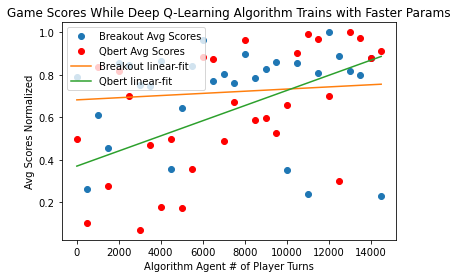

In [132]:
TEST_SET_1 = avg_game_scores_qbert_training
TEST_SET_2 = avg_game_scores_breakout_training
# normalize data
TEST_SET_1 = [i/max(TEST_SET_1) for i in TEST_SET_1]
TEST_SET_2 = [i/max(TEST_SET_2) for i in TEST_SET_2]
len_1 = [i * 500 for i, v in enumerate(TEST_SET_1)]
len_2 = [i * 500 for i, v in enumerate(TEST_SET_2)]
x = np.array(len_1)
y = np.array(TEST_SET_1)
m, b = np.polyfit(x, y, 1)

x_b = np.array(len_2)
y_b = np.array(TEST_SET_2)
m_b, b_b = np.polyfit(x_b, y_b, 1)

plt.plot(x, y, 'o')

plt.plot(x_b, y_b, 'ro')

plt.plot(x, m*x + b)
plt.plot(x_b, m_b*x_b + b_b)
plt.title('Game Scores While Deep Q-Learning Algorithm Trains with Faster Params')
plt.ylabel('Avg Scores Normalized')
plt.xlabel('Algorithm Agent # of Player Turns')
plt.legend(['Breakout Avg Scores', 'Qbert Avg Scores', 'Breakout linear-fit', 'Qbert linear-fit'], loc='upper left')
plt.show()

In [ ]:
# NUM_OBSERVABLE_STEPS = 500
# SAMPLE_SCORE_INTERVAL = 10
# SCREEN_LOG_FREQUENCY = 10

ENV_NAME = QBERT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
avg_game_scores_qbert_training, max_qbert_score_trend = train(ENV_NAME)

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image-shape-framework (InputLay (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
normalize-images (Lambda)       (None, 84, 84, 4)    0           image-shape-framework[0][0]      
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 20, 20, 16)   4112        normalize-images[0][0]           
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 9, 9, 32)     8224        conv2d_103[0][0]                 
___________________________________________________________________________________________

In [48]:
qbert_training = [125.0, 125.0, 175.0, 200.0, 450.0, 75.0, 125.0, 75.0, 250.0,
                  75.0, 0.0, 150.0, 25.0, 75.0, 75.0, 100.0, 450.0, 125.0, 
                  100.0, 625.0, 100.0, 225.0, 475.0, 100.0, 50.0, 100.0, 125.0, 
                  225.0, 50.0, 150.0, 100.0, 0.0, 425.0, 25.0, 200.0, 475.0,
                  125.0, 0.0, 175.0, 150.0, 600.0, 450.0, 175.0, 500.0, 100.0,
                  575.0, 500.0, 50.0, 525.0, 150.0, 700.0, 475.0, 525.0, 500.0,
                  500.0, 475.0, 525.0, 725.0, 650.0, 625.0, 725.0, 750.0, 650.0,
                  675.0, 625.0, 375.0, 600.0, 675.0, 600.0, 175.0, 700.0, 675.0,
                  700.0, 650.0, 725.0]

In [194]:
ENV_NAME = ATARI_BREAKOUT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
avg_game_scores_breakout_training, max_score_trend = train(ENV_NAME)

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image-shape-framework (InputLay (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
normalize-images (Lambda)       (None, 84, 84, 4)    0           image-shape-framework[0][0]      
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 20, 20, 16)   4112        normalize-images[0][0]           
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 9, 9, 32)     8224        conv2d_59[0][0]                  
___________________________________________________________________________________________

KeyboardInterrupt: 

In [103]:
breakout_training = [0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0,
                     2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 3.0, 1.0,
                     2.0, 4.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0,
                     0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0,
                     6.0, 0.0, 3.0, 2.0, 0.0, 2.0, 0.0, 1.0, 3.0,
                     1.0, 1.0, 2.0, 7.0, 2.0, 1.0, 1.0, 2.0, 3.0,
                     2.0, 2.0, 1.0, 2.0, 5.0, 4.0, 0.0, 3.0, 3.0,
                     3.0, 2.0, 0.0, 3.0, 1.0, 1.0, 3.0, 0.0, 2.0,
                     4.0, 1.0, 1.0, 4.0, 3.0, 6.0, 7.0, 5.0, 4.0,
                     7.0, 2.0, 3.0]

In [104]:
LOGS_FILE_PATH_BREAKOUT = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/at-20201203045323-time-BreakoutDeterministic-v4.h5'
LOGS_FILE_PATH_QBERT = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/at-20201202210524-time-QbertDeterministic-v4.h5'
RENDER = False
NUM_GAMES = 2000

In [96]:
# Required Step: Manually update file in RESTORE_FILE_PATH for testing.
ENV_NAME = ATARI_BREAKOUT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
test_data_breakout = test(ATARI_BREAKOUT_ENV_NAME, LOGS_FILE_PATH_BREAKOUT)

,  3.98
,  3.96
,  4.0
,  4.0
,  3.98
,  3.98
,  4.0
,  4.0
,  3.96
,  4.0
,  4.0
,  4.0
,  3.96
,  4.0
,  4.0
,  4.02
,  4.0
,  4.0
,  3.98
,  3.96
,  3.94
,  3.98
,  3.98
,  4.02
,  4.0
,  3.94
,  4.0
,  4.0
,  3.94
,  4.0
,  3.98
,  3.98
,  4.0
,  4.0
,  4.0
,  3.96
,  4.0
,  4.0
,  4.0
,  3.98


In [105]:
test_data_qbert = [3.98, 3.96, 3.98, 4.0, 4.0, 4.0]

In [ ]:
ENV_NAME = QBERT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
avg_game_scores_qbert_testing = test(ENV_NAME, LOGS_FILE_PATH_TEST)

In [97]:
ENV_NAME = QBERT_ENV_NAME
ACTION_OPTION_COUNT = get_action_count(ENV_NAME)
avg_game_scores_qbert_testing = test(QBERT_ENV_NAME, LOGS_FILE_PATH_QBERT)

,  11.96
,  11.98
,  12.0
,  12.12
,  12.08
,  12.0
,  12.0
,  12.1
,  12.18
,  12.0
,  12.0
,  12.0
,  12.0
,  12.0
,  11.98
,  12.04
,  12.0
,  12.02
,  12.0
,  12.06
,  12.0
,  12.0
,  12.0
,  12.0
,  12.0
,  12.0
,  12.0
,  12.0
,  12.1
,  12.0
,  11.98
,  11.98
,  12.06
,  11.98
,  12.02
,  12.1
,  12.0
,  12.0
,  11.96
,  12.04


In [106]:
def normalize_data(data_list):
    return [i/max(data_list) for i in data_list]

In [107]:
breakout_training_normalized = normalize_data(breakout_training)
qbert_training_normalized = normalize_data(qbert_training)

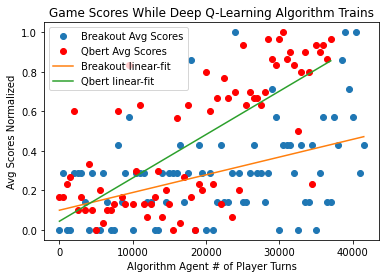

In [108]:
TEST_SET_1 = breakout_training_normalized
TEST_SET_2 = qbert_training_normalized
len_1 = [i * 500 for i, v in enumerate(TEST_SET_1)]
len_2 = [i * 500 for i, v in enumerate(TEST_SET_2)]
x = np.array(len_1)
y = np.array(TEST_SET_1)
m, b = np.polyfit(x, y, 1)

x_b = np.array(len_2)
y_b = np.array(TEST_SET_2)
m_b, b_b = np.polyfit(x_b, y_b, 1)

plt.plot(x, y, 'o')

plt.plot(x_b, y_b, 'ro')

plt.plot(x, m*x + b)
plt.plot(x_b, m_b*x_b + b_b)
plt.title('Game Scores While Deep Q-Learning Algorithm Trains')
plt.ylabel('Avg Scores Normalized')
plt.xlabel('Algorithm Agent # of Player Turns')
plt.legend(['Breakout Avg Scores', 'Qbert Avg Scores', 'Breakout linear-fit', 'Qbert linear-fit'], loc='upper left')
plt.show()

test data samples, breakout:  [3.98, 3.96, 4.0, 4.0, 3.98, 3.98, 4.0, 4.0, 3.96, 4.0, 4.0, 4.0, 3.96, 4.0, 4.0, 4.02, 4.0, 4.0, 3.98, 3.96, 3.94, 3.98, 3.98, 4.02, 4.0, 3.94, 4.0, 4.0, 3.94, 4.0, 3.98, 3.98, 4.0, 4.0, 4.0, 3.96, 4.0, 4.0, 4.0, 3.98]
test data samples, qbert:  [11.96, 11.98, 12.0, 12.12, 12.08, 12.0, 12.0, 12.1, 12.18, 12.0, 12.0, 12.0, 12.0, 12.0, 11.98, 12.04, 12.0, 12.02, 12.0, 12.06, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.1, 12.0, 11.98, 11.98, 12.06, 11.98, 12.02, 12.1, 12.0, 12.0, 11.96, 12.04]


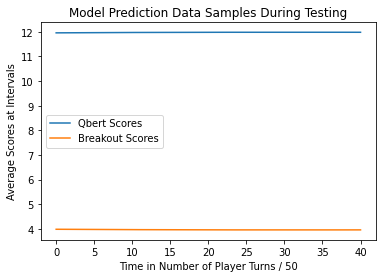

In [102]:
from scipy.interpolate import make_interp_spline
def normalize_data(my_data):
    return [i/len(my_data) for i in my_data]
# test_data_breakout = [3.98, 3.96, 3.98, 4.0, 4.0, 4.0]
# test_data_qbert = [ 12.0, 12.14, 11.98, 12.2, 12, 12]
TEST_DATA_1 = test_data_breakout
# qbert.
TEST_DATA_2 = avg_game_scores_qbert_testing


x_len = len(TEST_DATA_1)
time_series = [i * 50 for i in range(0, x_len)]
x_len_minus = x_len

x = np.array(time_series[:x_len_minus])
y_b = np.array(TEST_DATA_1[:x_len_minus])
y_s = np.array(TEST_DATA_2[:x_len_minus])
x_new = np.linspace(0, len(time_series), 10000)

a_BSpline_b = make_interp_spline(x, y_b)
a_BSpline_s = make_interp_spline(x, y_s)

y_new_b = a_BSpline_b(x_new)
y_new_s = a_BSpline_s(x_new)

plt.plot(x_new, y_new_s)
plt.plot(x_new, y_new_b)

print('test data samples, breakout: ', TEST_DATA_1)
print('test data samples, qbert: ', TEST_DATA_2)
plt.title('Model Prediction Data Samples During Testing')
plt.ylabel('Average Scores at Intervals')
plt.xlabel('Time in Number of Player Turns / 50')
plt.legend(['Qbert Scores', 'Breakout Scores'], loc='center left')
plt.show()

In [ ]:
# from fist 4700 games of breakout recorded, but thread never finished before interruption so copied them over.
x = [0, 3.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0]
y = [0.0, 5.0, 3.0, 3.0, 4.0, 3.0, 4.0, 0.0, 5.0, 5.0, 5.0, 0.0, 3.0, 3.0, 0.0, 0.0, 2.0, 4.0, 5.0]
z = [10.0, 3.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 4.0, 4.0, 8.0, 2.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, 4.0]
a = [0.0, 3.0, 0.0, 2.0, 3.0, 0.0, 4.0, 4.0, 0.0, 4.0, 4.0, 4.0, 1.0, 3.0, 0.0, 0.0, 3.0, 3.0, 3.0]
b = [0.0, 5.0, 4.0, 3.0, 3.0, 5.0, 3.0, 4.0, 3.0, 5.0, 3.0, 3.0, 3.0, 5.0, 3.0, 5.0, 0.0, 3.0, 4.0]

In [ ]:
print(avg_game_scores_breakout_testing)

In [ ]:
# training three commits back.